Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

In [3]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data\\sr\\restored_image.png'

# Load image and baselines

HR and LR resolutions: (608, 544), (152, 136)


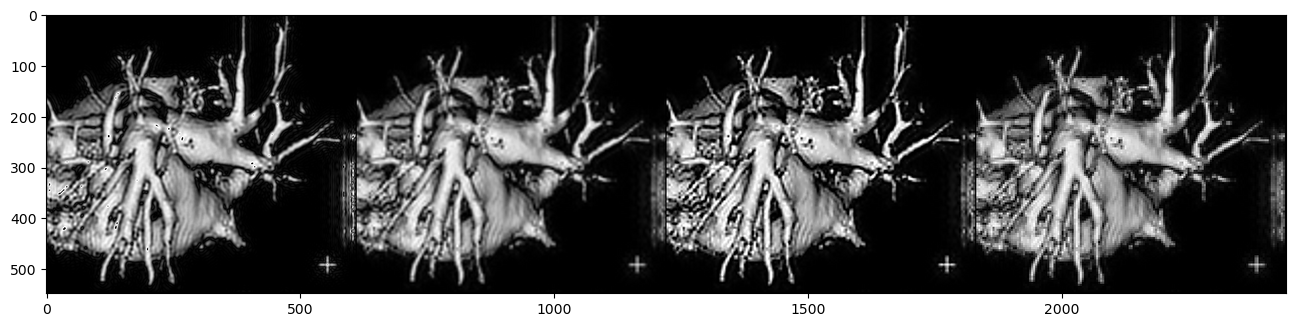

PSNR bicubic: 27.9391   PSNR nearest: 23.8032


C:\Users\mrfri\AppData\Local\Temp\ipykernel_39952\2872063453.py:24: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  compare_psnr(imgs['HR_np'], imgs['bicubic_np']),
C:\Users\mrfri\AppData\Local\Temp\ipykernel_39952\2872063453.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  compare_psnr(imgs['HR_np'], imgs['nearest_np'])))


In [5]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image, imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

# 将基准图像转换为单通道或三通道
def convert_to_single_channel(img):
    if img.shape[0] == 4:
        img = img[:3, :, :]  # 取前三个通道（RGB）
    if img.shape[0] == 3:
        img = img[0, :, :]  # 取出第一个通道
        img = np.expand_dims(img, axis=0)  # 添加一个新的轴，使其变为 (1, height, width)
    return img

imgs['bicubic_np'] = convert_to_single_channel(imgs['bicubic_np'])
imgs['sharp_np'] = convert_to_single_channel(imgs['sharp_np'])
imgs['nearest_np'] = convert_to_single_channel(imgs['nearest_np'])
imgs['HR_np'] = convert_to_single_channel(imgs['HR_np'])
imgs['LR_np'] = convert_to_single_channel(imgs['LR_np'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4, 12)
    print('PSNR bicubic: %.4f   PSNR nearest: %.4f' % (
        compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [6]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [7]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'UNet' # UNet, ResNet
net = get_net(input_depth, 'UNet', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

reflection
reflection
reflection
reflection
reflection
reflection
reflection
reflection
reflection


# Define closure and optimize

In [8]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)
    
    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()
    
    out_HR_np = out_HR.detach().cpu().numpy()[0]  # 取出第一个样本
    if out_HR_np.shape[0] == 3:
        out_HR_np = out_HR_np[0, :, :]  # 取出第一个通道
        out_HR_np = np.expand_dims(out_HR_np, axis=0)  # 添加一个新的轴，使其变为 (1, height, width)

    out_LR_np = out_LR.detach().cpu().numpy()[0]
    if out_LR_np.shape[0] == 3:
        out_LR_np = out_LR_np[0, :, :]  # 取出第一个通道
        out_LR_np = np.expand_dims(out_LR_np, axis=0)  # 添加一个新的轴，使其变为 (1, height, width)

    
    psnr_LR = compare_psnr(imgs['LR_np'], out_LR_np)
    psnr_HR = compare_psnr(imgs['HR_np'], out_HR_np)
    
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)

    i += 1
    
    return total_loss

Starting optimization with ADAM


c:\Users\mrfri\.conda\envs\deep-image-prior\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 136, 152])) that is different to the input size (torch.Size([1, 3, 136, 152])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\mrfri\AppData\Local\Temp\ipykernel_39952\2311768915.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  psnr_LR = compare_psnr(imgs['LR_np'], out_LR_np)
C:\Users\mrfri\AppData\Local\Temp\ipykernel_39952\2311768915.py:29: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  psnr_HR = compare_psnr(imgs['HR_np'], out_HR_np)


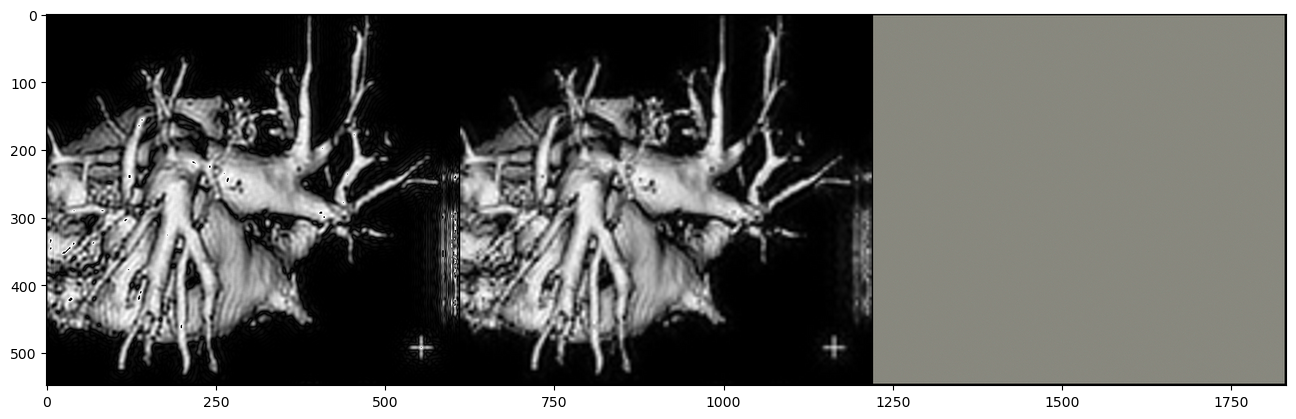

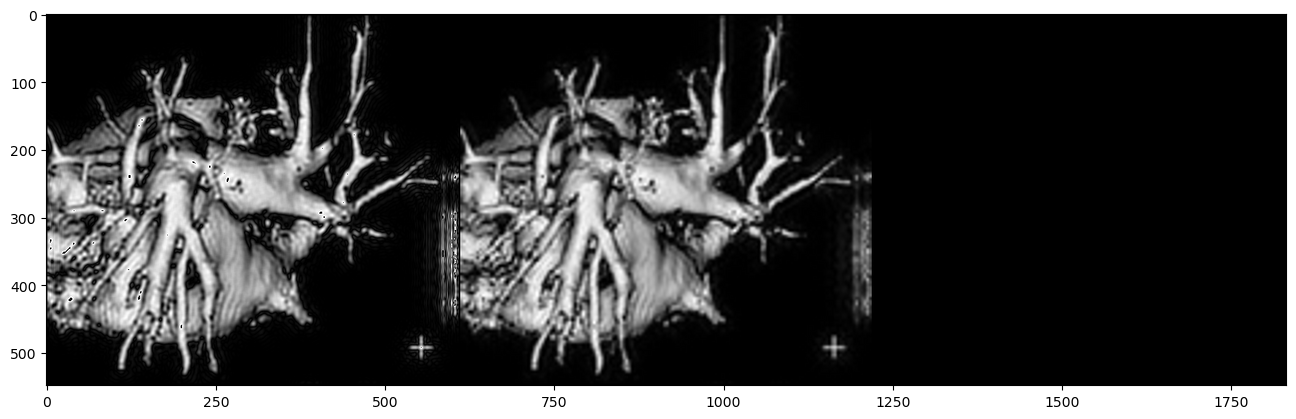

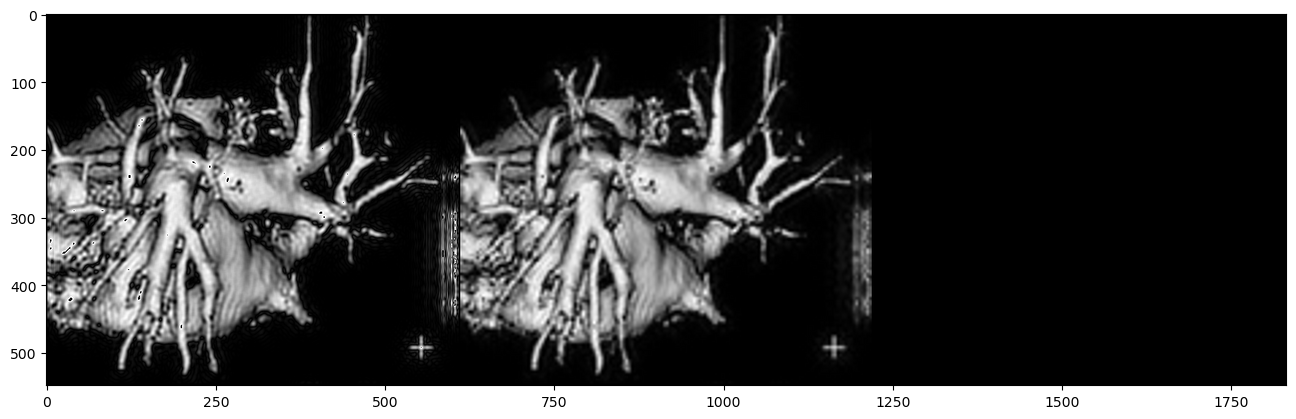

KeyboardInterrupt: 

In [9]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

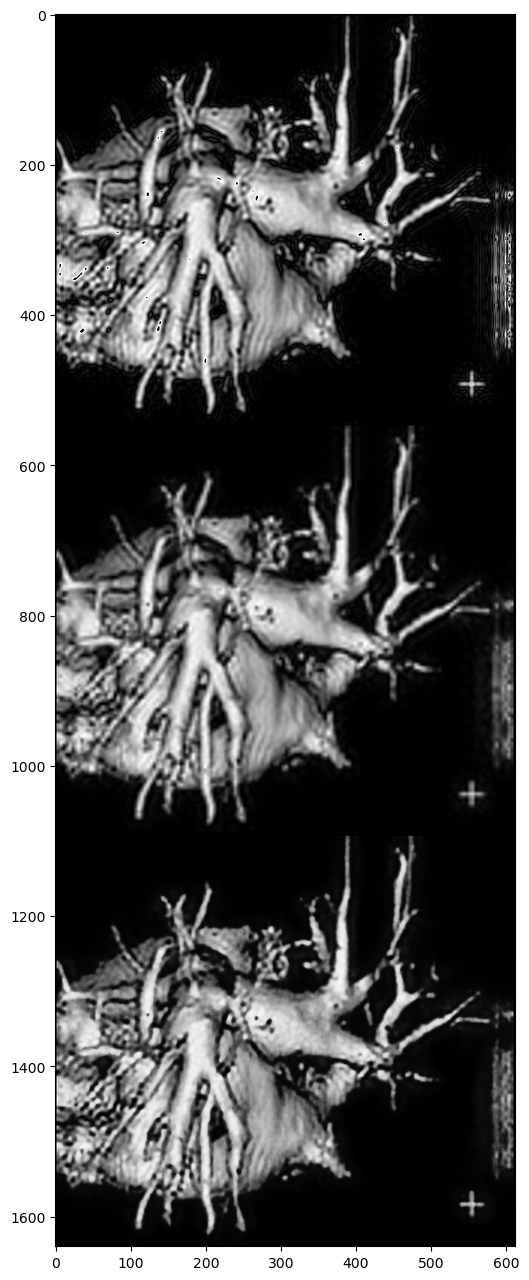

In [ ]:
from PIL import Image
import numpy as np
import os

# 将 PyTorch 张量转换为 NumPy 数组，并裁剪到 [0, 1] 范围内
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# 绘制图像网格
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1)

# 指定保存文件夹路径
save_folder = 'D:\\CODE\\python-codes\\deep-image-prior-master\\saved_images'

# 确保保存文件夹存在
os.makedirs(save_folder, exist_ok=True)

# 将 NumPy 数组转换为 PIL 图像
def save_image(np_img, path):
    # 如果图像是单通道，去掉通道维度
    if np_img.shape[0] == 1:
        np_img = np_img[0]
        pil_img = Image.fromarray((np_img * 255).astype(np.uint8), mode='L')
    else:
        pil_img = Image.fromarray((np_img * 255).astype(np.uint8).transpose(1, 2, 0))
    # 保存为 PNG 文件
    pil_img.save(path)

# 保存结果图片
save_image(out_HR_np, os.path.join(save_folder, 'result_deep_prior.png'))
save_image(imgs['HR_np'], os.path.join(save_folder, 'HR_image.png'))
save_image(imgs['bicubic_np'], os.path.join(save_folder, 'bicubic_image.png'))